In [1]:
import os
import json
import sys
sys.path.append("../")

from tqdm import tqdm
import numpy as np
import utils

In [2]:
data_dir = "../../data/google_patents/us-25000"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 10


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "patent_id": str,
    "title": [{"text": str, "language": str, "truncated": bool}],
    "description": [{"text": str, "language": str, "truncated": bool}],
    "claims": [{"text": str, "language": str, "truncated": bool}],
    "classifications": [{"code": str, "inventive": bool, "first": bool, "tree": List[str]}, ...]
}
```

In [4]:
sample_doc_file = doc_files[0]
with open(sample_doc_file, "r") as f:
    for line in f:
        sample_doc = json.loads(line)
        break
sample_doc["classifications"]

[{'code': 'A46B11/0006', 'inventive': True, 'first': True, 'tree': []},
 {'code': 'A46B9/023', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A45D24/28', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B5/0095', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A45D24/22', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B11/002', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B2200/104', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B9/023', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B2200/104', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A45D24/22', 'inventive': False, 'first': False, 'tree': []},
 {'code': 'A46B11/0006', 'inventive': True, 'first': True, 'tree': []},
 {'code': 'A46B5/0095', 'inventive': True, 'first': False, 'tree': []},
 {'code': 'A46B11/002', 'inventive': False, 'first': False, 'tree': []}]

In [5]:
def get_id(doc):
    return doc["patent_id"]

def get_content(doc):
    return "\n".join(c["text"] for c in doc["claims"])

def get_title(doc):
    return "\n".join(c["text"] for c in doc["title"])

def get_label(doc):
    return list(set(x["code"][:4] for x in doc["classifications"]))

def get_sample(doc):
    return {"id": get_id(doc), "title": get_title(doc), "content": get_content(doc), "labels": get_label(doc)}

In [6]:
samples = []
for fname in doc_files:
    with open(fname, "r") as f:
        for line in f:
            doc = json.loads(line)
            if get_label(doc):
                samples.append(get_sample(doc))
        
doc_ids = random_state.permutation([x["id"] for x in samples if x["labels"]])
print("Number of valid documents:", len(doc_ids))

Number of valid documents: 21747


In [7]:
split_ids = {}
last_id = 0

for data_type in ("train", "dev", "test"):
    num_samples = int(data_ratio[data_type] * len(doc_ids))
    split_ids[data_type] = doc_ids[last_id : last_id + num_samples]
    last_id += num_samples
    
split_ids

{'train': array(['US-1086026-A', 'US-10446879-B2', 'US-2008193475-A1', ...,
        'US-2018315664-A1', 'US-10514782-B2', 'US-10209632-B2'],
       dtype='<U16'),
 'dev': array(['US-10385381-B2', 'US-10720723-B2', 'US-10287701-B2', ...,
        'US-7527811-B2', 'US-10135434-B2', 'US-7460518-B1'], dtype='<U16'),
 'test': array(['US-9897040-B2', 'US-2011078884-A1', 'US-4351119-A', ...,
        'US-3941221-A', 'US-2016123831-A1', 'US-9700800-B2'], dtype='<U16')}

In [8]:
for sample in samples:
    id = sample["id"]
    sample["is_train"] = id in split_ids["train"]
    sample["is_dev"] = id in split_ids["dev"]
    sample["is_test"] = id in split_ids["test"]

In [9]:
labels = set()
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        if sample["labels"]:
            f.write(json.dumps(sample, ensure_ascii=False) + "\n")
            labels.update(sample["labels"])

label_ids = {x : i for i, x in enumerate(sorted(labels))}
utils.dump_json(label_ids, save_label_path)

100%|██████████| 21747/21747 [00:01<00:00, 20889.15it/s]


In [12]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,content,labels,is_train,is_dev,is_test
0,US-10194740-B2,Fluid dispensing brush assembly,I claim: \n \n 1. A fluid dispensing...,"[A46B, A45D]",True,False,False
1,US-10033661-B1,Tiered priority system and callout performance...,What is claimed is: \n \n 1. A metho...,"[G06F, H04L]",True,False,False
2,US-10027048-B2,Electrical component and electronic device,What is claimed is: \n \n 1. An elec...,[H01R],True,False,False
3,US-10077129-B2,Labeler with sealing label press-on device,What is claimed is: \n \n 1. A label...,[B65C],True,False,False
4,US-10193177-B2,Fuel cell system and operating method therefor,The invention claimed is: \n \n 1. A...,"[Y02T, H01M, Y02E]",True,False,False
...,...,...,...,...,...,...,...
21742,US-10235166-B1,Code quality evaluation and user interfaces,What is claimed is: \n \n 1. A metho...,[G06F],True,False,False
21743,US-10030890-B2,Hinge apparatus,What is claimed is: \n \n 1. A hinge...,"[E05D, F16M, F24H, G09F, F23M]",True,False,False
21744,US-10076584-B2,Low odor latex paint capable of reducing inter...,What is claimed is: \n \n 1. A paint...,"[Y10T, A61L, C08K, C09D]",True,False,False
21745,US-10066520-B2,Valve opening and closing timing control appar...,What is claimed is: \n \n 1. A valve...,[F01L],False,False,True


In [24]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(17397, 2174, 2174)

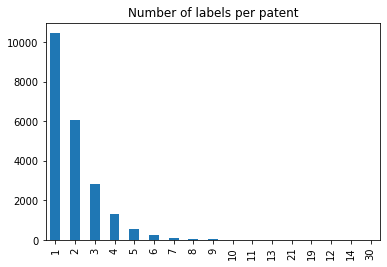

In [23]:
ax = df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");

In [26]:
df["content"].apply(lambda x : len(x.split())).mean()

822.8826504805261

In [29]:
len(label_ids)

633